In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from ast import literal_eval
import glob
import sys
sys.path.append("../scripts")
import preprocessing_census_blocks
import prediction_census_blocks

In [5]:
blocks_train, blocks_val, blocks_test = prediction_census_blocks.load_blocks_df()
blocks_df = pd.concat([blocks_train, blocks_val, blocks_test], axis=0)
print(blocks_df.isna().mean())
print(f"Total of {blocks_df.shape[0]} blocks")

Unnamed: 0           0.0
state                0.0
county               0.0
tract                0.0
block group          0.0
pop                  0.0
mhi                  0.0
year                 0.0
ed_attain            0.0
area                 0.0
density              0.0
city_state           0.0
n_patches            0.0
most_commom_scene    0.0
filenames            0.0
dtype: float64
Total of 42723 blocks


## Patches distribution

In [12]:
blocks_geo_df = gpd.read_file("../data/census_blocks.geojson")
for col in ["state", "county", "tract", "block group"]:
    blocks_geo_df[col] = blocks_geo_df[col].astype(int)
blocks_df = blocks_df.merge(
    blocks_geo_df,
    how="left",
    on=["state", "county", "tract", "block group"],
    suffixes=("!", ""),
)
blocks_df = blocks_df.drop(columns=[col for col in blocks_df.columns if "!" in col])
blocks_df = gpd.GeoDataFrame(blocks_df, geometry="geometry")
blocks_df = blocks_df.to_crs("EPSG:4326")

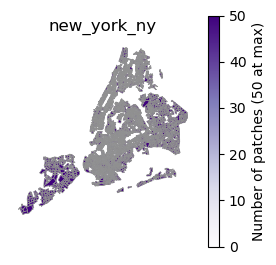

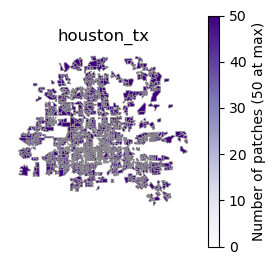

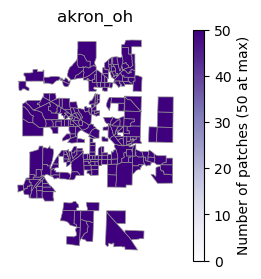

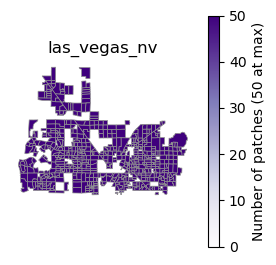

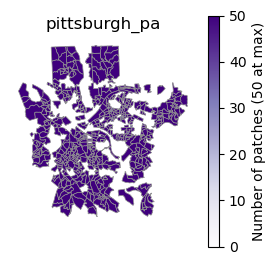

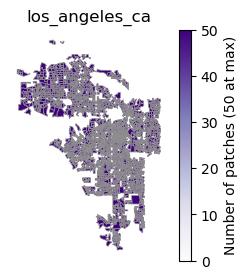

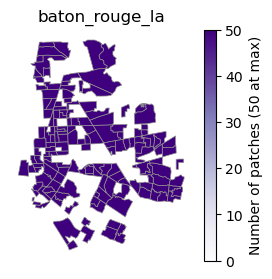

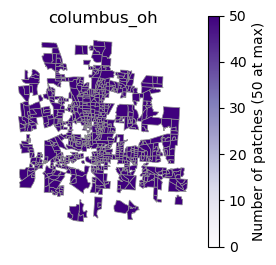

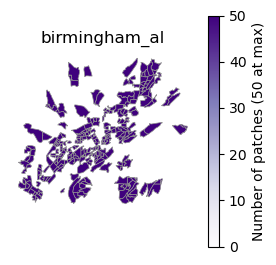

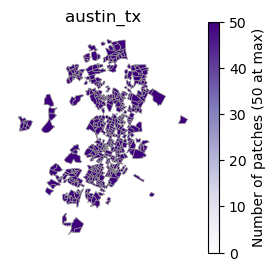

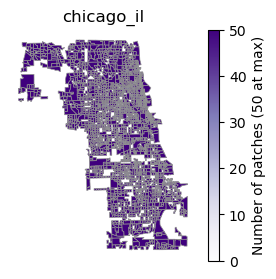

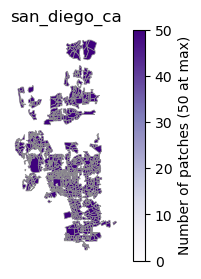

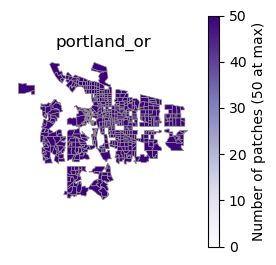

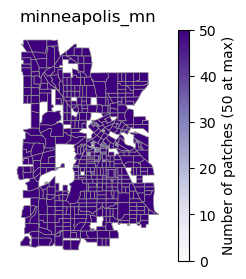

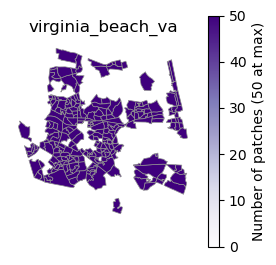

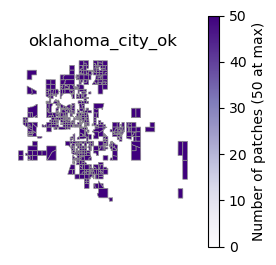

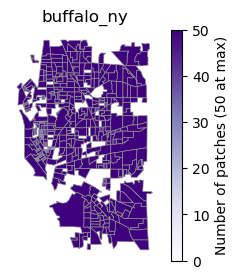

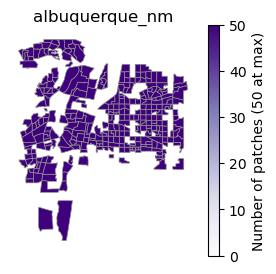

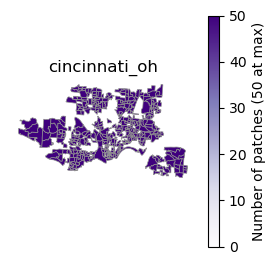

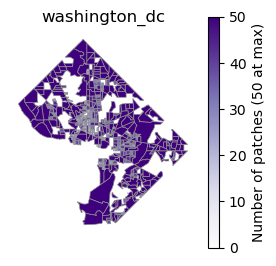

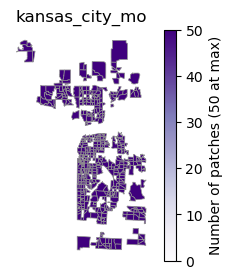

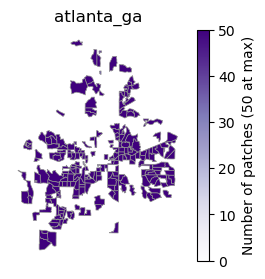

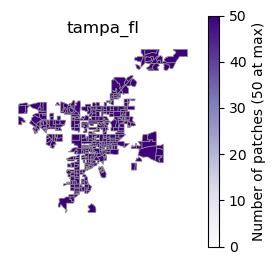

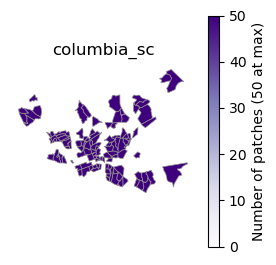

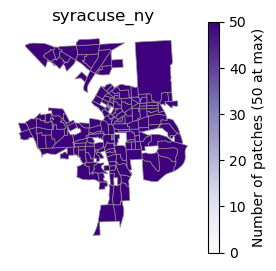

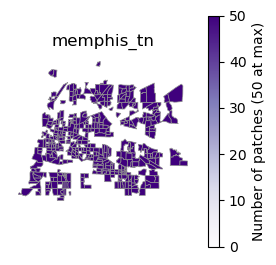

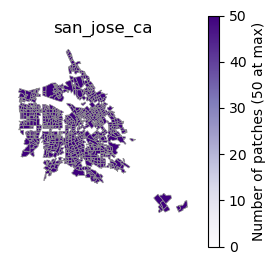

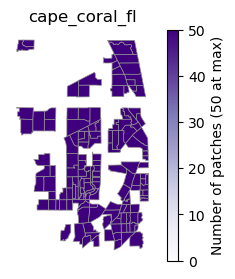

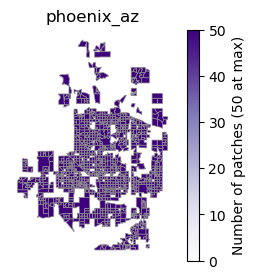

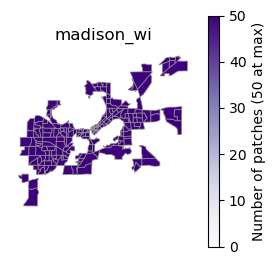

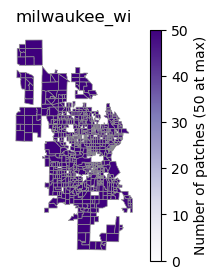

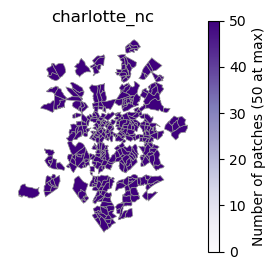

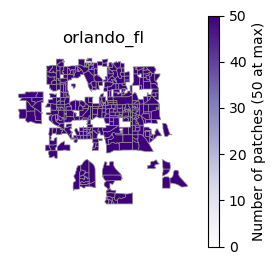

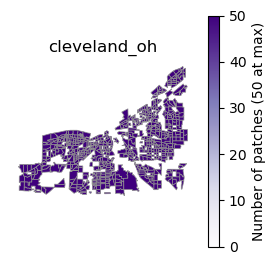

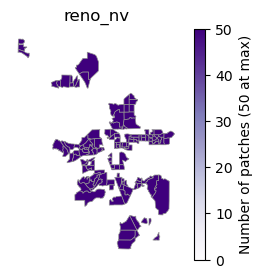

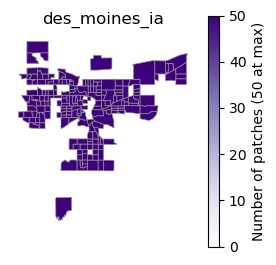

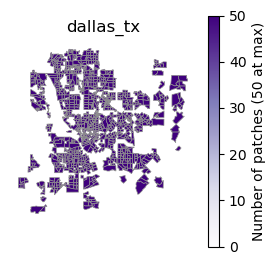

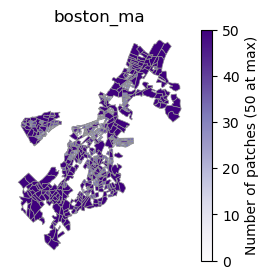

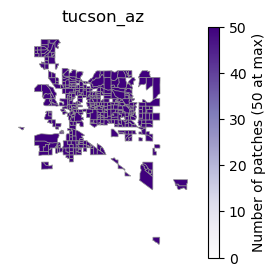

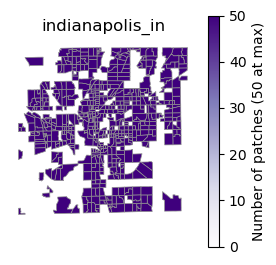

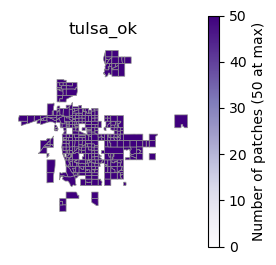

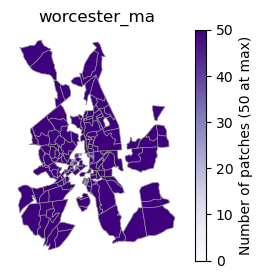

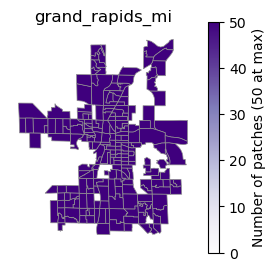

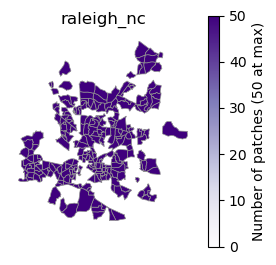

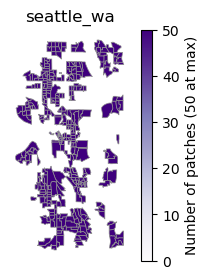

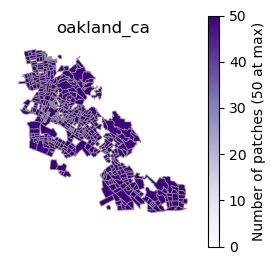

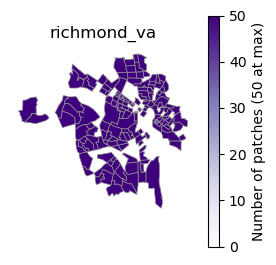

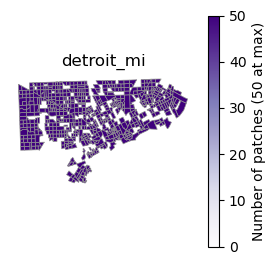

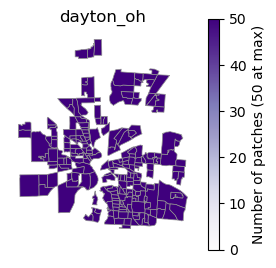

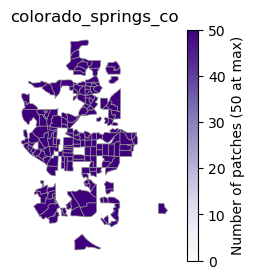

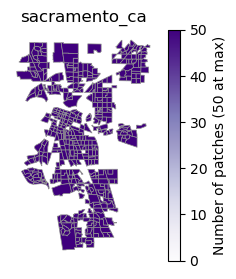

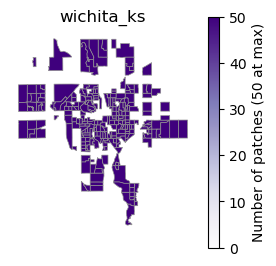

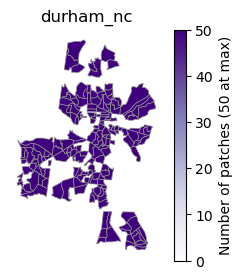

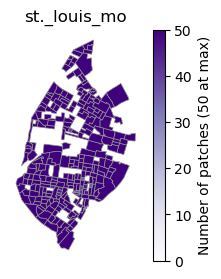

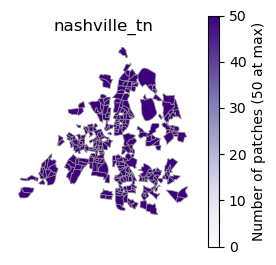

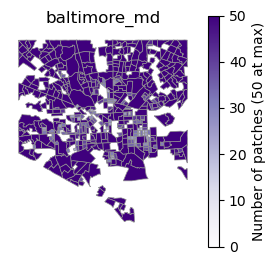

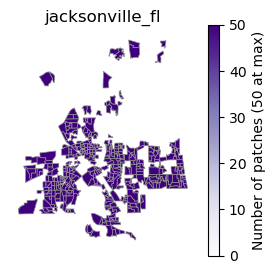

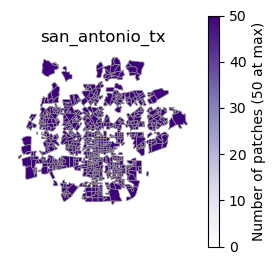

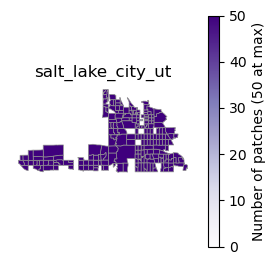

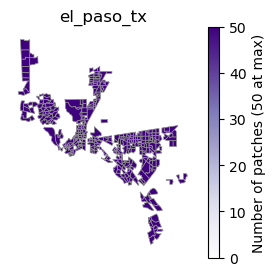

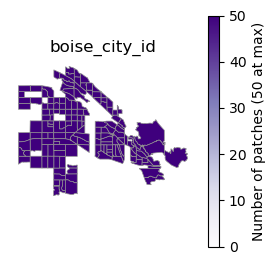

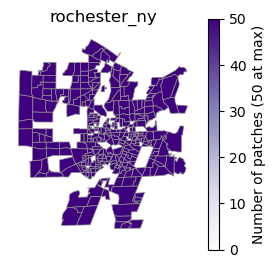

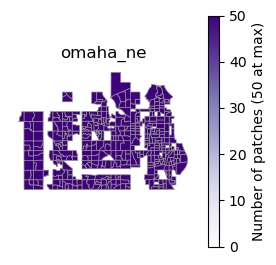

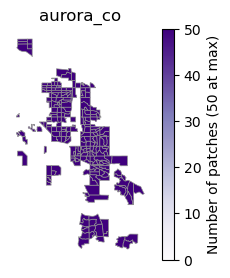

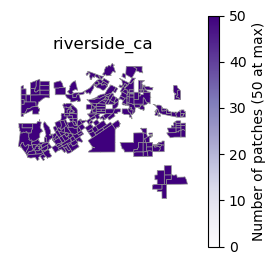

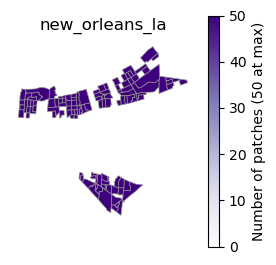

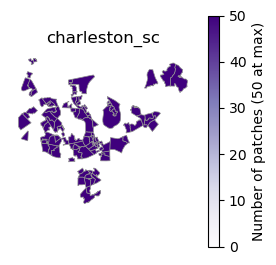

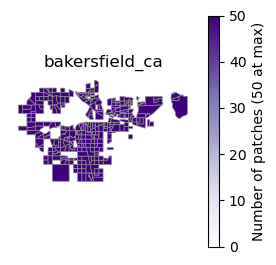

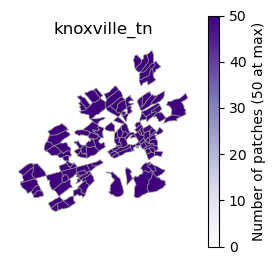

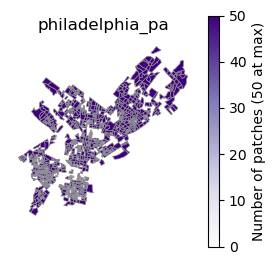

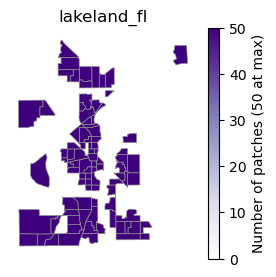

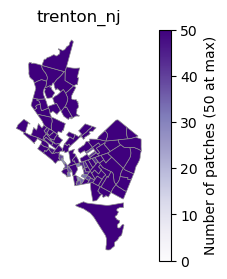

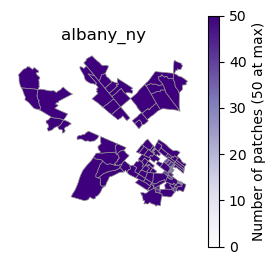

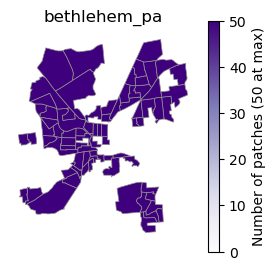

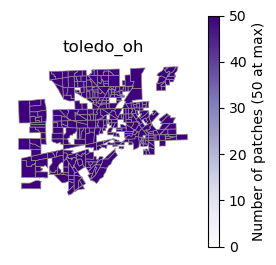

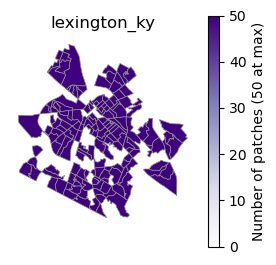

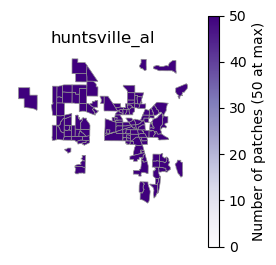

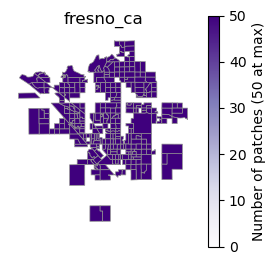

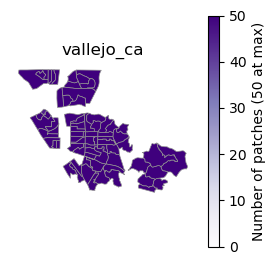

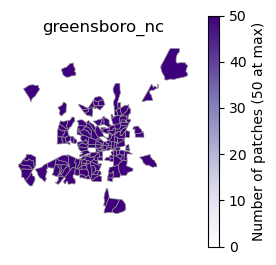

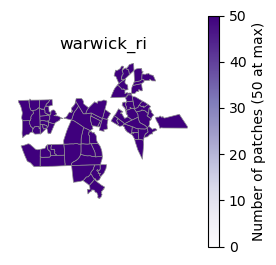

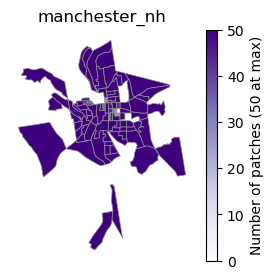

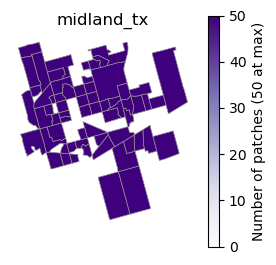

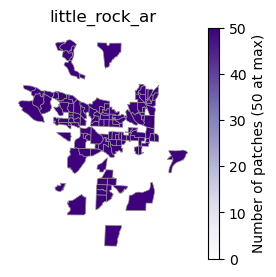

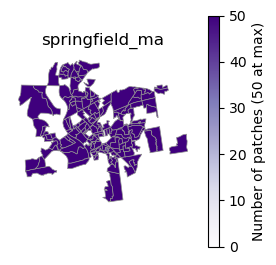

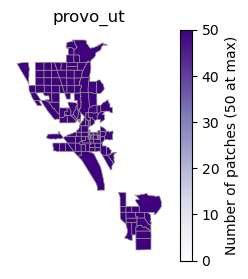

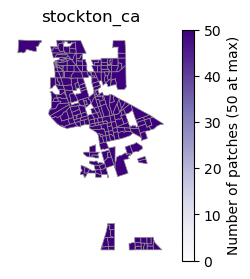

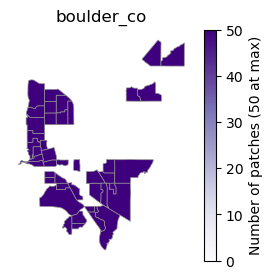

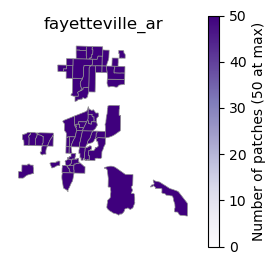

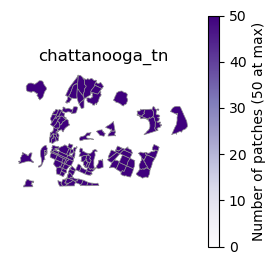

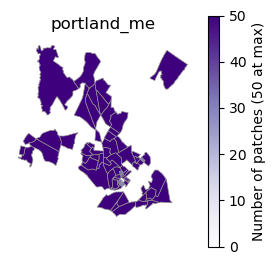

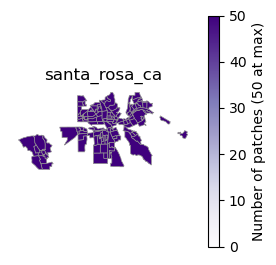

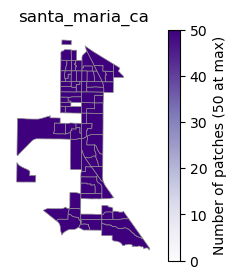

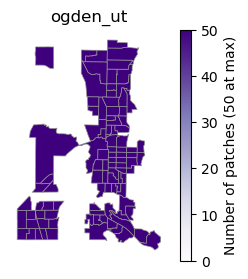

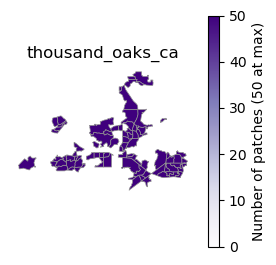

In [13]:
unique_cities = blocks_df.city_state.unique()
for city_state in unique_cities:
    fig, ax = plt.subplots(figsize=(3, 3))
    blocks_df[blocks_df.city_state == city_state].plot(
        ax=ax, 
        ec= "#909090", 
        lw = 0.5,  
        column = "n_patches", 
        cmap = "Purples",
        legend=True,
        legend_kwds={"label": "Number of patches (50 at max)"},
        vmax = 50,
        vmin = 0
        )
    plt.axis("off")
    plt.title(city_state)
    plt.show()

### Plotting patches and blocks

In [42]:
import shapely

In [43]:
def split_rectangle(rect):
    x0, y0, x1, y1 = rect.bounds
    x_mid = (x0 + x1) / 2
    y_mid = (y0 + y1) / 2
    return [
        shapely.geometry.box(x0, y0, x_mid, y_mid),
        shapely.geometry.box(x_mid, y0, x1, y_mid),
        shapely.geometry.box(x0, y_mid, x_mid, y1),
        shapely.geometry.box(x_mid, y_mid, x1, y1),
    ]

def split_patches_df(patches_df):
    new_df = []
    for i, row in patches_df.iterrows():
        new_geom = split_rectangle(row["geometry"])
        for j in range(4):
            new_row = row.copy()
            new_row["geometry"] = new_geom[j]
            new_row["idx"] = j
            new_df.append(new_row)
    new_df = gpd.GeoDataFrame(new_df)
    new_df = new_df.set_crs(patches_df.crs)
    return new_df

In [100]:
def plot_block_images(selected_block, ax = None):
    filenames = selected_block.filenames.values[0]
    filenames_without_idx = [f.split(" ")[0] for f in filenames]
    filenames_without_idx = [f.split("/")[-1] for f in filenames_without_idx]
    filenames = [f.split("/")[-1] for f in filenames]
    
    # loading geojson of patches in this city
    city_state = selected_block.city_state.values[0]
    patches_geo_df = glob.glob(f"../data/output/patches/{city_state}/*.geojson")
    patches_geo_df_list = []
    for f in patches_geo_df:
        temp_df = gpd.read_file(f)
        # keeping only the lines that are in the selected block
        temp_df = temp_df[temp_df.patche_filename.isin(filenames_without_idx)]
        if temp_df.shape[0] > 0:
            patches_geo_df_list.append(temp_df)
    patches_geo_df = pd.concat(patches_geo_df_list)
    patches_geo_df = split_patches_df(patches_geo_df)
    patches_geo_df["patche_filename_idx"] = patches_geo_df["patche_filename"] + " " + patches_geo_df["idx"].astype(str)
    patches_geo_df = patches_geo_df[patches_geo_df["patche_filename_idx"].isin(filenames)]
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    
    x, y = selected_block.geometry.values[0].exterior.coords.xy
    ax.plot(x, y, color="#303030", lw = 2, zorder = 3)
    
    for i, row in patches_geo_df.iterrows():
        img = plt.imread(f"../data/output/patches/{city_state}/{row.patche_filename}")
        img = img.transpose(1, 0, 2)
        # flip image horizontally
        img = img[:, ::-1, :]

        j = row["idx"]
        row_ = j // 2
        column_ = j % 2
        img = img[
            row_ * 112 : (row_ + 1) * 112, column_ * 112 : (column_ + 1) * 112, :]

        # plot inside the patch bounds
        xmin, ymin, xmax, ymax = row.geometry.bounds
        ax.imshow(img, extent=[xmin, xmax, ymin, ymax], zorder = 1)
        x, y = row.geometry.exterior.coords.xy
        ax.plot(x, y, color="#eeeeee", lw = 1, zorder = 3)

    xmin, ymin, xmax, ymax = patches_geo_df.geometry.total_bounds
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

    #plot block polygon
    

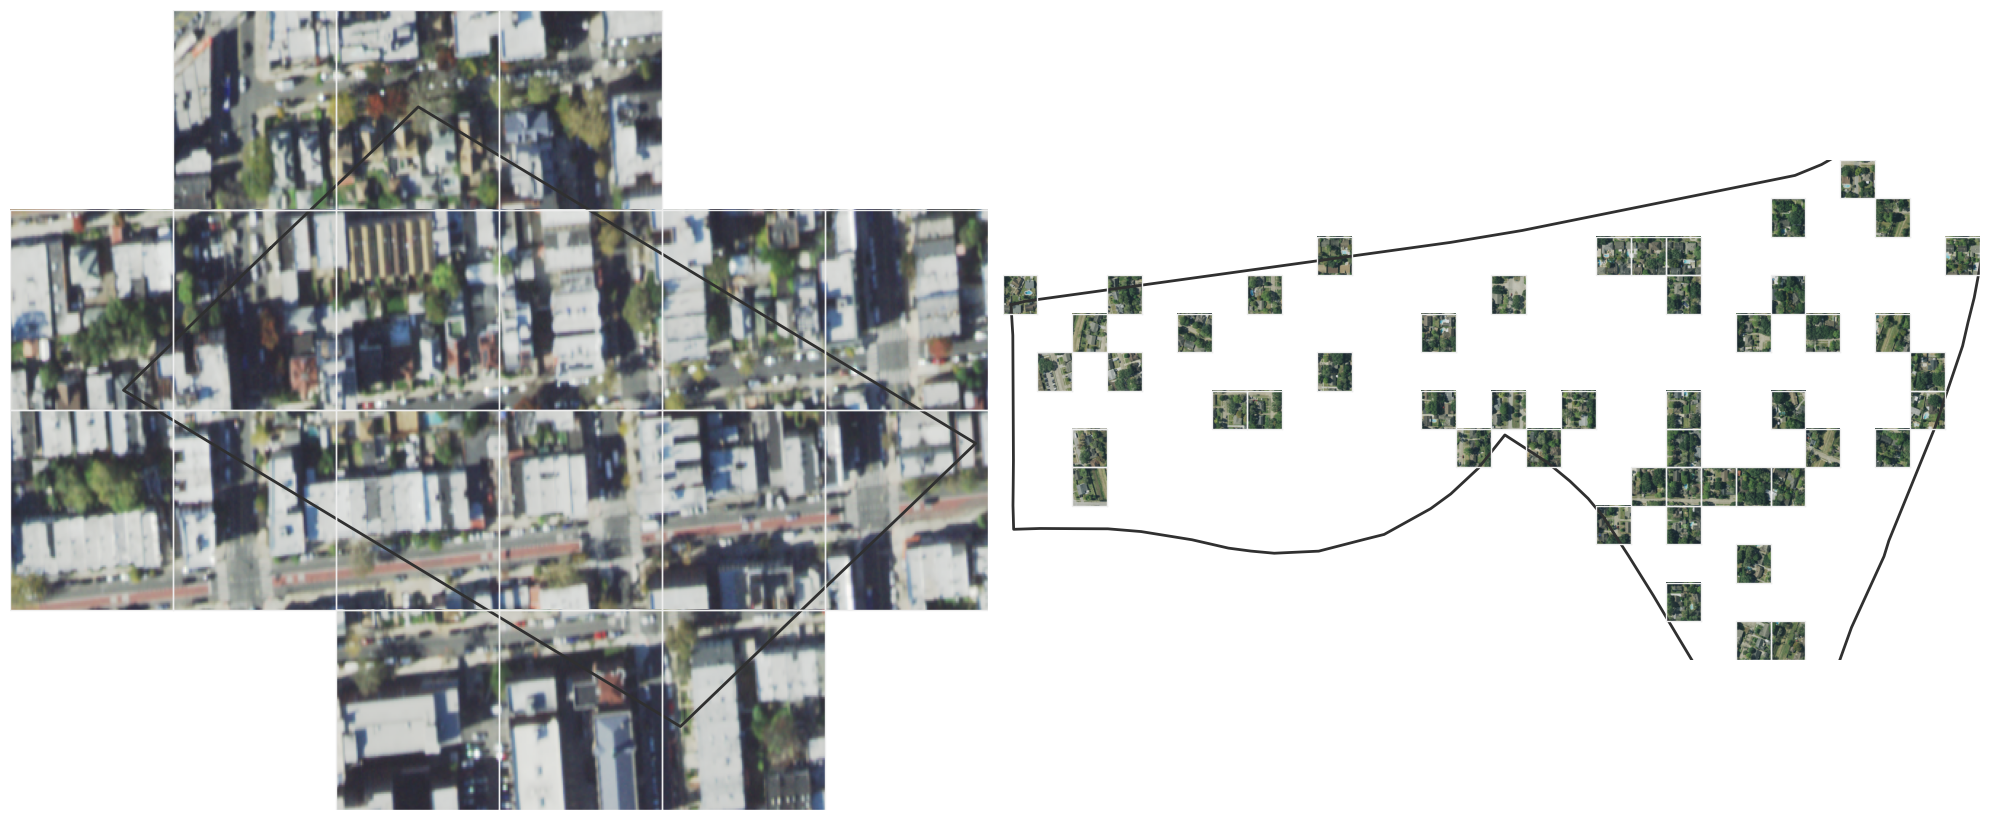

In [111]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 18))#, gridspec_kw={"width_ratios" : [3, 5]})
plot_block_images(blocks_df[blocks_df.city_state == "new_york_ny"].iloc[[15], :], ax = axs[0])
plot_block_images(blocks_df[blocks_df.city_state == "houston_tx"].iloc[[18], :], ax = axs[1])

for i in range(2):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_axis_off()
    axs[i].set_aspect("equal")
#axs[0].set_title("New York")
#axs[1].set_title("Houston")


plt.tight_layout()
plt.savefig("figures/blocks.pdf", dpi = 300)
plt.show()

## Testing cropping blocks

In [48]:
import paramiko
from osgeo import gdal
from rasterio.mask import mask
import rasterio
import os
from PIL import Image

In [49]:
vidagpu_username = "gav9890"
vidagpu_password = "vida1309"
ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(
    "vidagpu.poly.edu", username=vidagpu_username, password=vidagpu_password
)

In [50]:
sftp = ssh.open_sftp()
sftp.chdir("/vida/work/GDPFinder/GDPFinder/data/output/unzipped_files")
dir_contents = sftp.listdir()
    # keep only tif files
dir_contents = [f for f in dir_contents if f.endswith(".tif")]
entity_id =[f.split("_")[0] for f in dir_contents]

In [51]:
blocks_df["name"] = blocks_df.state.apply(str) + " " + blocks_df.county.apply(str) + " " + blocks_df.tract.apply(str) + " " + blocks_df["block group"].apply(str)

In [ ]:
# block warnings
import warnings
warnings.filterwarnings("ignore")


for city_state in unique_cities:
    blocks_df_city = blocks_df[blocks_df.city_state == city_state]

    # load scenes of city
    scenes_shapefile_city = [f for f in scenes_shapefile if city_state in f]
    scenes_shapefile_city = pd.concat([gpd.read_file(f) for f in scenes_shapefile_city])
    scenes_shapefile_city = gpd.GeoDataFrame(scenes_shapefile_city, geometry="geometry")

    # project to projected coordinate system
    scenes_shapefile_city = scenes_shapefile_city.to_crs("EPSG:3857")
    blocks_df_city = blocks_df_city.to_crs("EPSG:3857")
    
    # for each block
    for i, row in blocks_df_city.iterrows():
        # get scenes that intersect with it
        scenes_shapefile_city_block = scenes_shapefile_city[scenes_shapefile_city.intersection(row.geometry).area >= row.geometry.area]
        if len(scenes_shapefile_city_block) == 0:
            continue
        else:
            # get scene from entity id
            scenes_shapefile_city_block_entity_id = scenes_shapefile_city_block.entity_id.values[0]
            # get tif file from entity id
            tif_file = [f for f in dir_contents if f.split("_")[0] == scenes_shapefile_city_block_entity_id][0]

            sftp.get(tif_file, "temp.tif")
            tif = gdal.Open("temp.tif")
            row = gpd.GeoDataFrame(row).T
            row.crs = "EPSG:3857"
            row = row.to_crs(tif.GetProjectionRef())
            xmin, ymin, xmax, ymax = row.geometry.values[0].bounds
            # mask and crop tif
            tif = rasterio.open("temp.tif")
            out_image, out_transform = mask(tif, [row.geometry.values[0]], crop=True)
            # plot and save
            #Image.fromarray(out_image[:3, : , :]).save(f"../data/output/blocks/{row['name'].values[0]}.png")
            Image.fromarray(out_image[:3, :, :].transpose(1, 2, 0), mode = "RGB").save(f"../data/output/blocks/{row['name'].values[0]}.png")
            #fig, ax = plt.subplots(figsize=(4, 4))
            #plt.imshow(out_image.transpose(1, 2, 0)[:, : , :3])
            #plt.axis("off")
            # remove white space
            #plt.savefig(f"../data/output/blocks/{row['name'].values[0]}.png", bbox_inches="tight")

            # remove temp tif file
            os.remove("temp.tif")
            # close files
            tif.close()
                    
    # if folder has more than 100 gb, stop
    if sum(os.path.getsize(f"../data/output/blocks/{f}") for f in os.listdir("../data/output/blocks")) > 100000000000:
        break